# Analysis of Sensor and Lab samples

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats

from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

In [3]:
processed_data_path = "/Users/massimilianoarca/Documents/PoliMi/Research Grant/SafeCREW/Data/Tarragona/Processed Data"

# Utils

In [4]:
# keys are for the lab, values are for the sensors
eb0_features_mapping = {
    # 'Alarma Espectral', # ALARMA ESPECTRAL
    "Color": "COLOR",  # COLOR
    "Conductivitat a 20oC": "COND",  # COND
    # 'Ox', # OX
    "Sòlids en suspensió": "PARTICULES",  # PARTICULES
    "pH": "PH",  # PH
    "Mercuri": "RATIO_HG",  # RATIO_HG
    # 'Ratio Terb Sig', # RATIO_TERB_SIG
    # 'Ratio Tlf Uv', # RATIO_TLF_UV
    "Sulfats": "SULFAT",  # SULFAT
    "Temperatura": "TEMP",  # TEMP
    # 'Temperatura Aigua', # TEMP_AIGUA
    "Terbolesa": "TERBOLESA",  # TERBOLESA
    # 'Tlf', # TLF
    "Índex UV": "UV254",  # UV254
    # 'Vis436', # VIS436
    # 'Vis525', # VIS525
    # 'Vis620', # VIS620
}

In [5]:
# keys are for the lab, values are for the sensors
eb1_features_mapping = {
    # 'Alarma Spectral', # ALARMA SPECTRAL
    "Clor lliure residual": "CLOR LLIURE",  # CLOR LLIURE
    "Color": "COLOR",  # COLOR
    "Conductivitat a 20oC": "CONDUCTIVITAT",  # CONDUCTIVITAT
    # 'DOC', # DOC
    # 'ORP', # ORP
    "Sòlids en suspensió": "PARTICULES",  # PARTICULES
    "pH": "PH",  # PH
    "Temperatura": "TEMPERATURA",  # TEMPERATURA
    "Terbolesa": "TERBOLESA SCAN",  # TERBOLESA SCAN
    # 'Tlf', # TLF
    "Carboni Orgànic Total Tractament": "TOC",  # TOC
    "Índex UV": "UVA",  # UVA
    # 'Vis436', # VIS436
    # 'Vis525', # VIS525
    # 'Vis620', # VIS620
}

In [6]:
import unicodedata

def normalize_string(s):
    return unicodedata.normalize('NFKD', s)

# Load Data

In [7]:
eb0_features_df = pd.read_excel(
    os.path.join(processed_data_path, "eb0_measure_features_dataset.xlsx")
)

eb0_targets_df = pd.read_excel(
    os.path.join(processed_data_path, "eb0_measure_targets_dataset.xlsx")
)

In [8]:
eb1_features_df = pd.read_excel(
    os.path.join(processed_data_path, "eb1_measure_features_dataset.xlsx")
)

eb1_targets_df = pd.read_excel(
    os.path.join(processed_data_path, "eb1_measure_targets_dataset.xlsx")
)

In [9]:
eb0_sensors_dict = {}
eb1_sensors_dict = {}

for file in os.listdir(processed_data_path):
    key = '_'.join(file.split('_')[3:])
    key, _ = os.path.splitext(key)

    if file.startswith("eb0_sensor"):
        eb0_sensors_dict[key] = pd.read_excel(
            os.path.join(processed_data_path, file)
        )
    elif file.startswith("eb1_sensor"):
        eb1_sensors_dict[key] = pd.read_excel(
            os.path.join(processed_data_path, file)
        )

In [10]:
thms_df = pd.read_excel(os.path.join(processed_data_path, "thms_dataset.xlsx"))

# Lab vs Sensor Data

## EB0

### Histograms

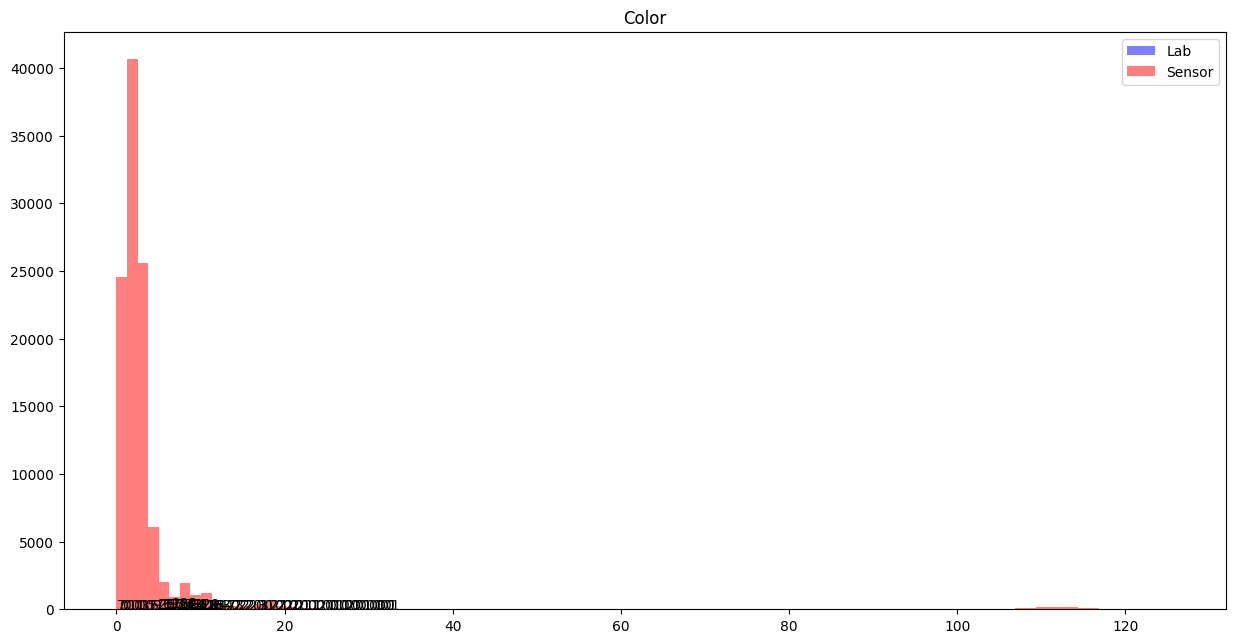

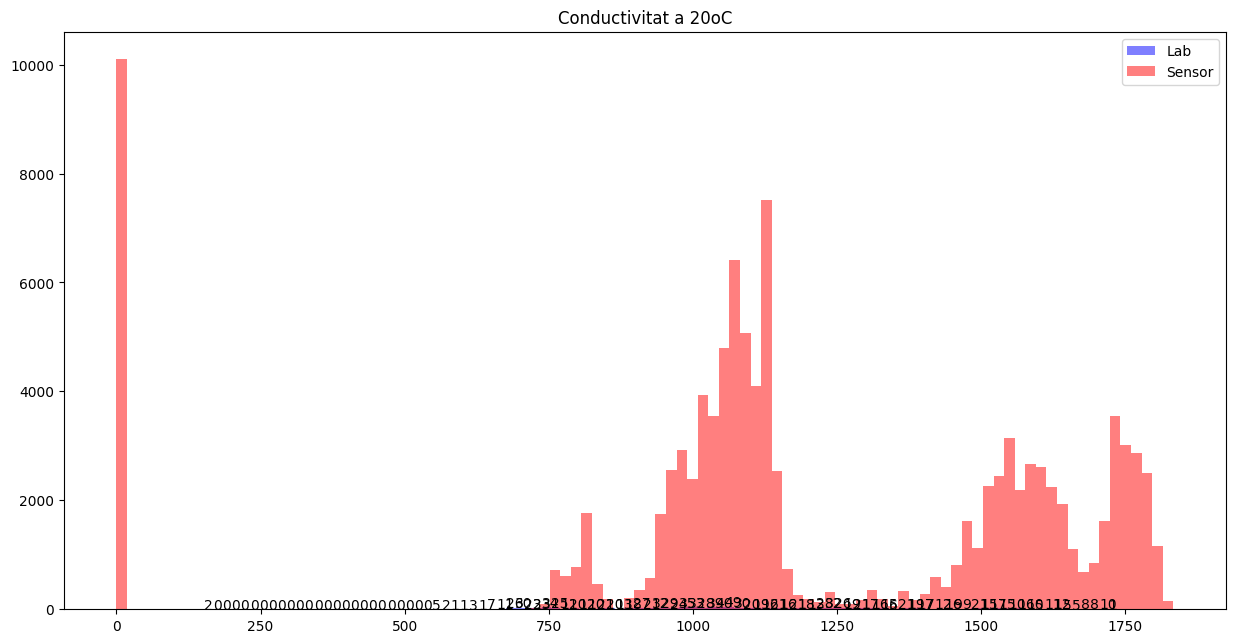

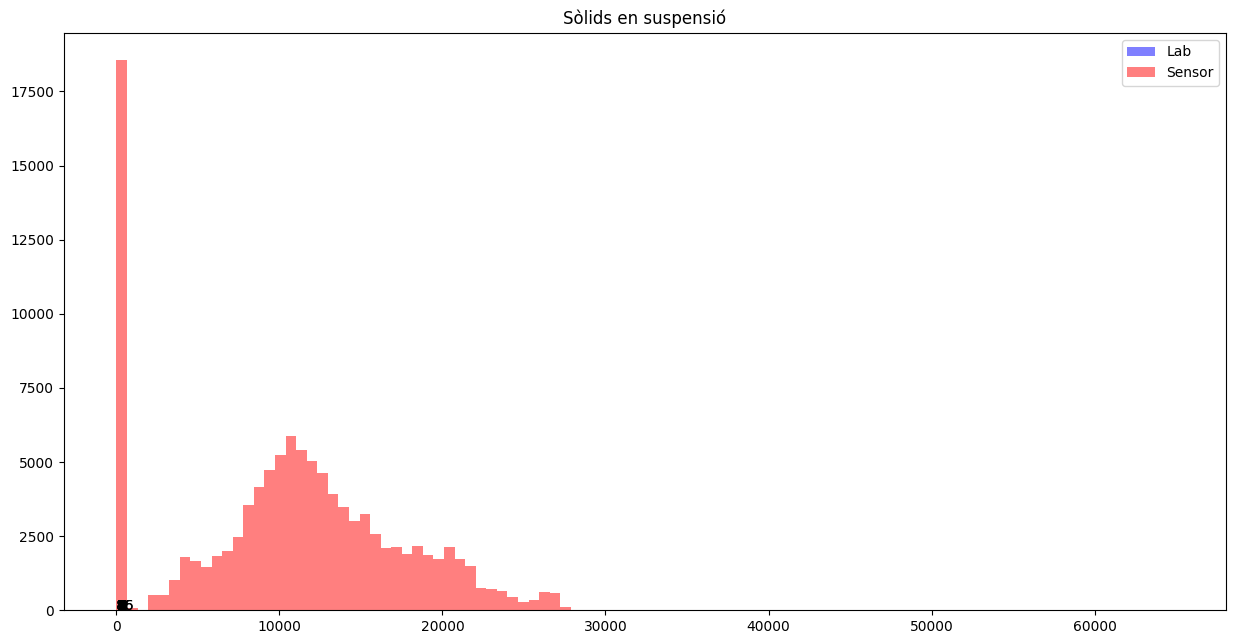

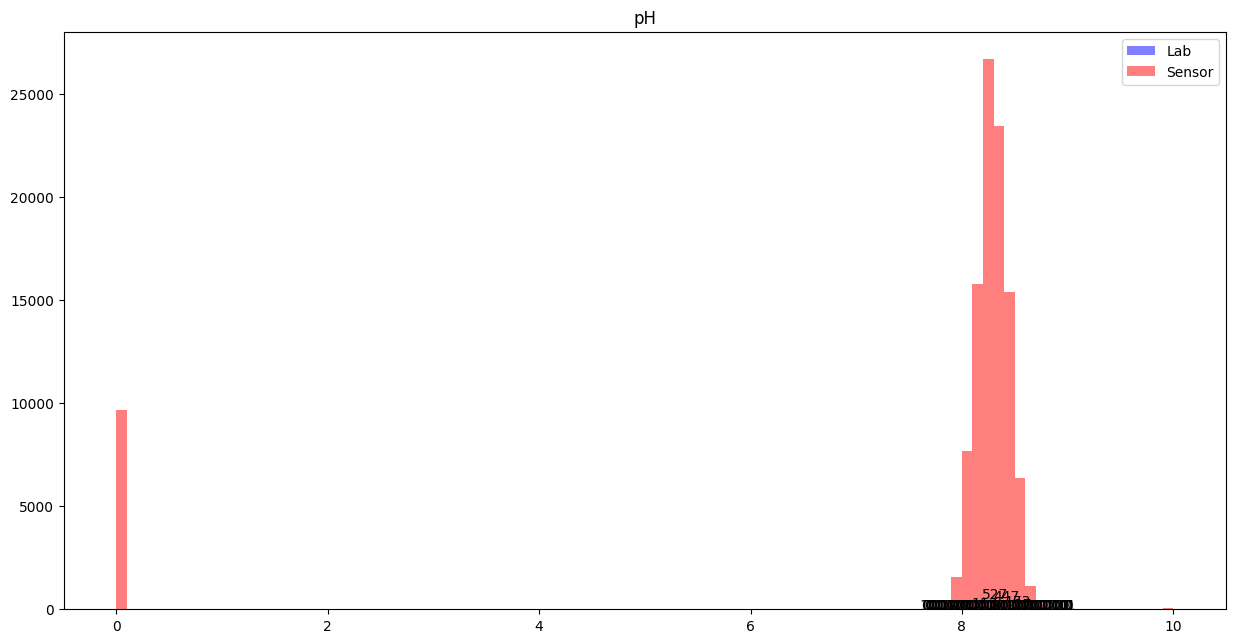

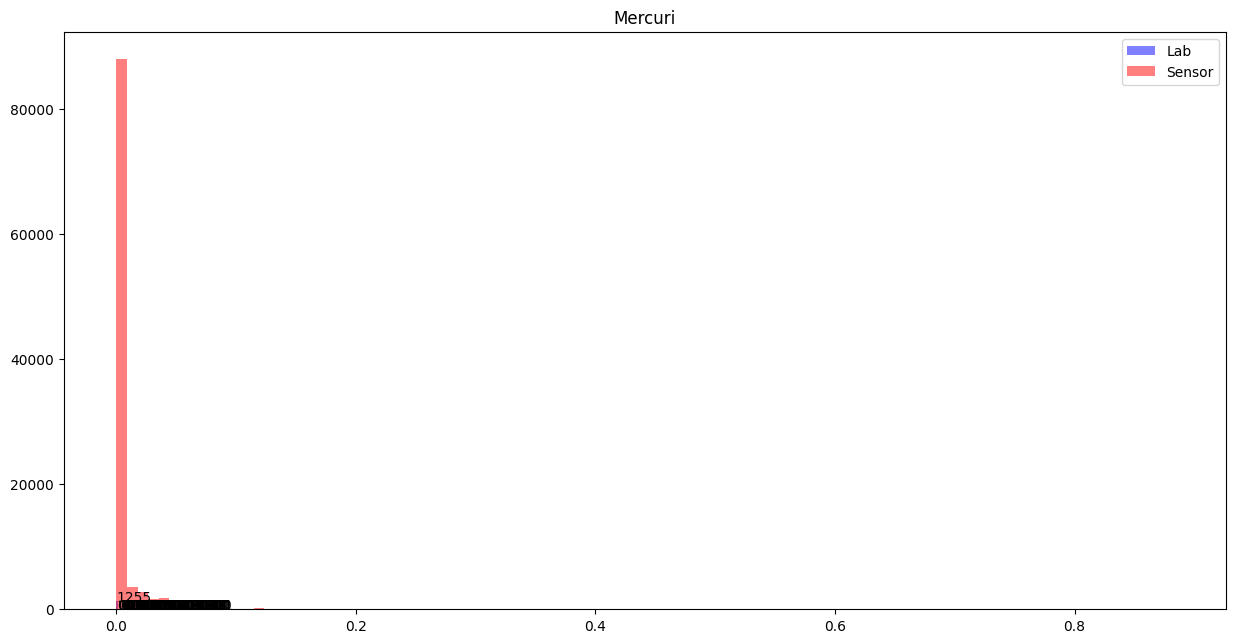

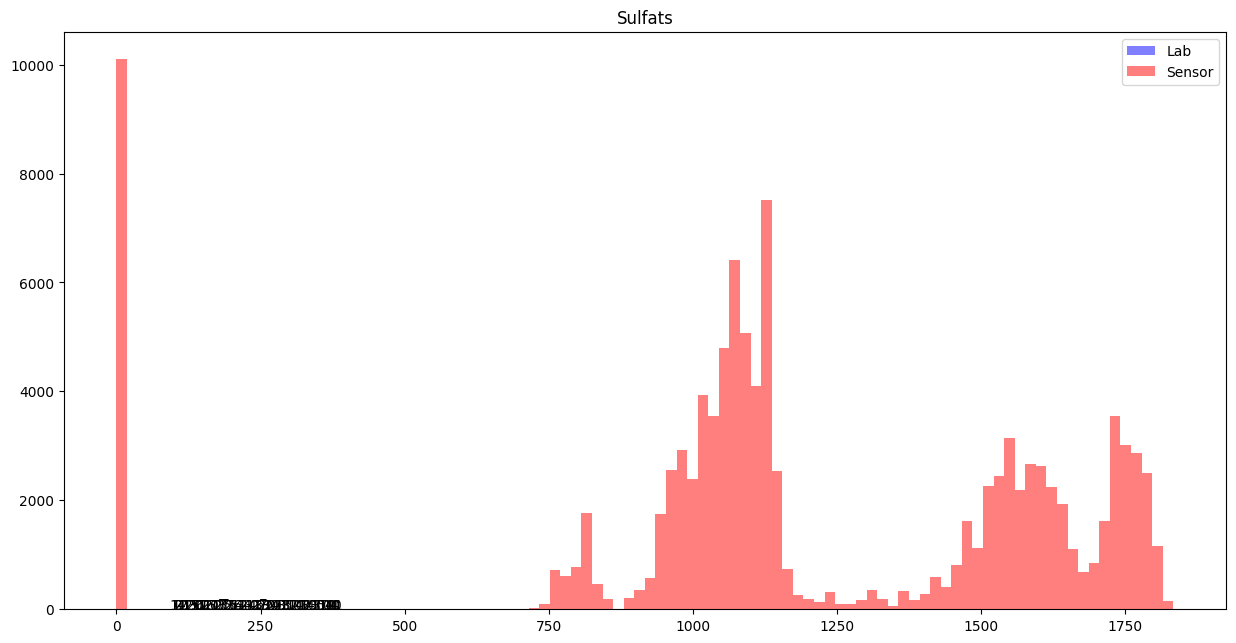

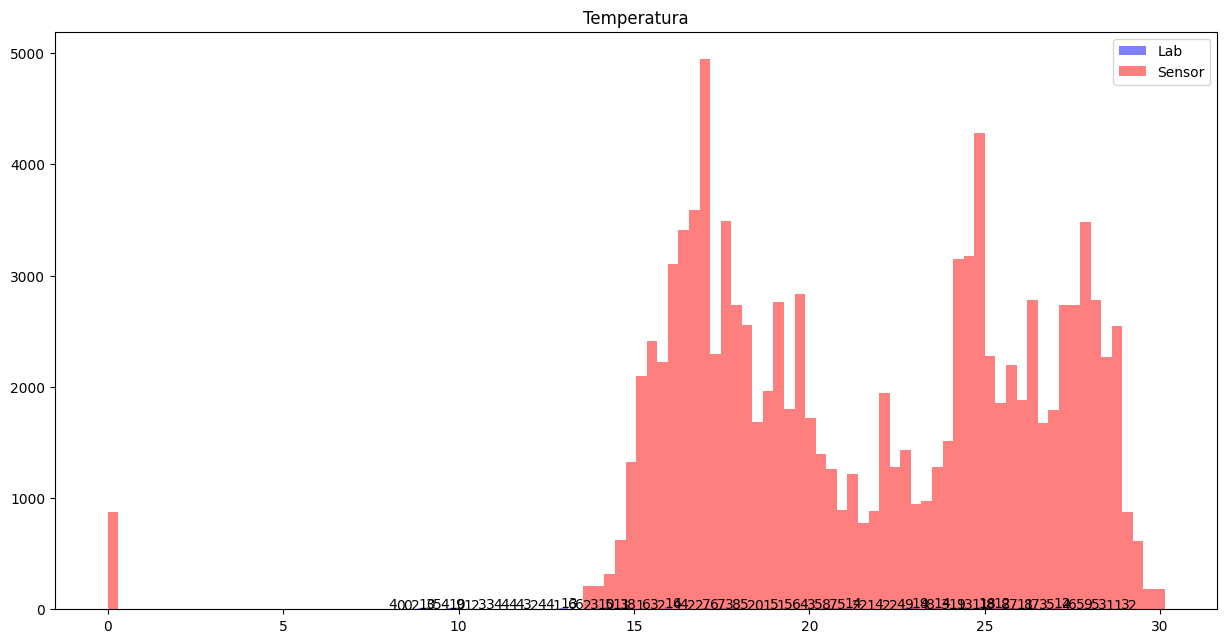

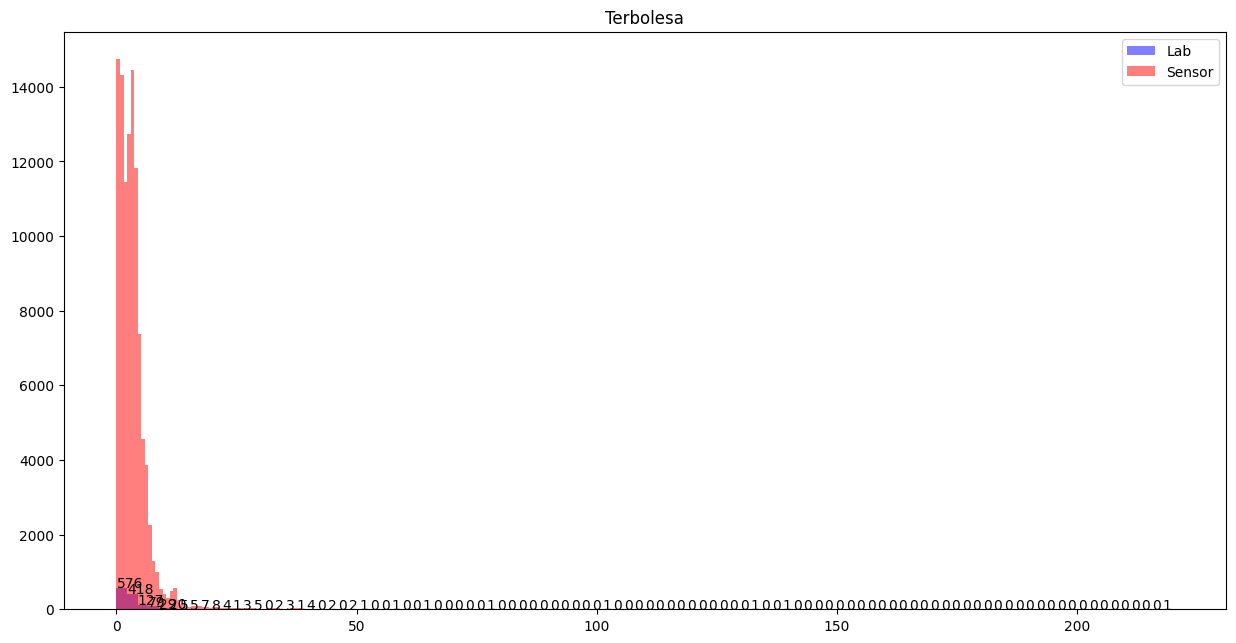

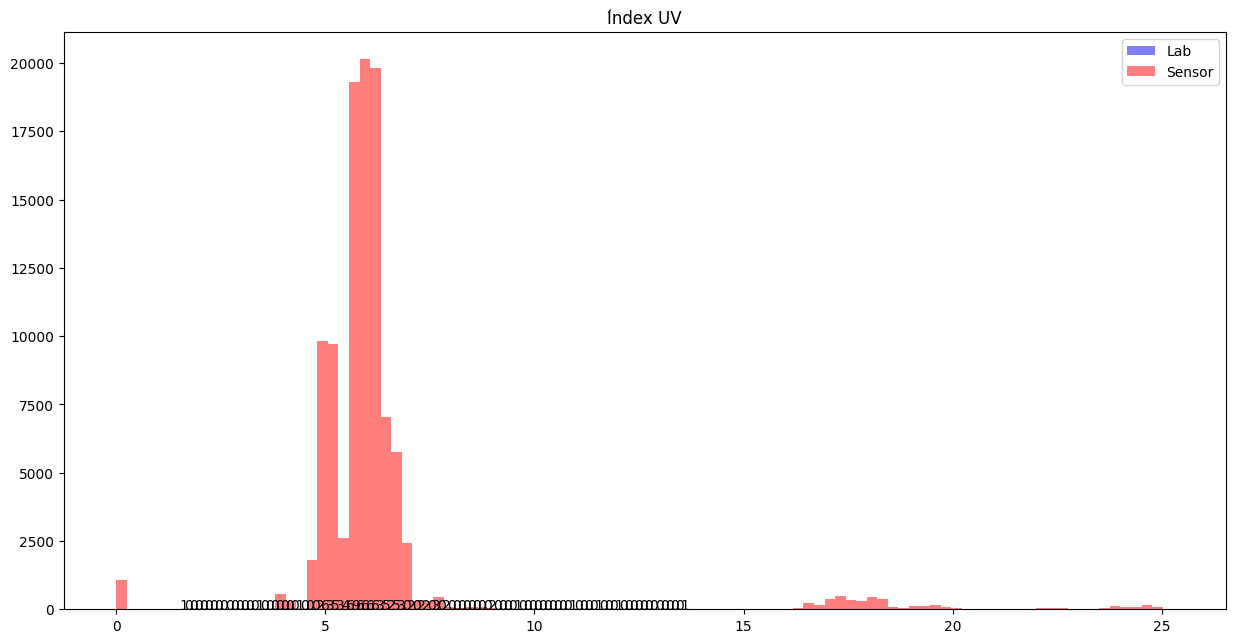

In [11]:
eb0_features_df['ANALYTE'] = eb0_features_df['ANALYTE'].apply(normalize_string)
eb0_features_mapping = {normalize_string(k): v for k, v in eb0_features_mapping.items()}

for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_df[eb0_features_df['ANALYTE'] == lab_key]
    sensor_df = eb0_sensors_dict[sensor_key]

    if not lab_df.empty and not sensor_df.empty:
        lab_df = lab_df.dropna(subset=['RESULTASNUMERIC'])

        plt.figure(figsize=(15, 7.5))

        counts, bins, patches = plt.hist(
            lab_df['RESULTASNUMERIC'],
            bins=100,
            color='blue',
            alpha=0.5,
            label='Lab'
        )
        # Add counts as annotations
        for count, bin in zip(counts, bins):
            plt.text(bin, count, str(int(count)))

        plt.hist(
            sensor_df[sensor_df.columns[1]],
            bins=100,
            color='red',
            alpha=0.5,
            label='Sensor'
        )
        plt.title(lab_key)
        plt.legend()
        plt.show()

### Distributions Divergence

In [12]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb0_features_mapping.items():

    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb0_features_df[eb0_features_df["ANALYTE"] == lab_key]
    sensor_df = eb0_sensors_dict[sensor_key]

    lab_pdist = np.histogram(
        lab_df["RESULTASNUMERIC"].dropna(), bins=100, density=True
    )[0]
    sensor_pdist = np.histogram(
        sensor_df[sensor_df.columns[1]].dropna(), bins=100, density=True
    )[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [13]:
kl_divs

Color                     5.195362
Conductivitat a 20oC      1.666654
Sòlids en suspensió     3.256159
pH                       26.845716
Mercuri                   0.213125
Sulfats                   4.036905
Temperatura              10.564687
Terbolesa                 0.605017
Índex UV                10.431955
dtype: float64

In [14]:
js_divs

Color                    0.798019
Conductivitat a 20oC     0.447468
Sòlids en suspensió    0.580288
pH                       0.828800
Mercuri                  0.231281
Sulfats                  0.596746
Temperatura              0.476187
Terbolesa                0.396276
Índex UV                0.781838
dtype: float64

In [15]:
tv_dists

Color                      1.871532
Conductivitat a 20oC       0.027219
Sòlids en suspensió      0.423251
pH                        40.566614
Mercuri                  513.429121
Sulfats                    0.165209
Temperatura                2.013532
Terbolesa                  0.458578
Índex UV                  5.805966
dtype: float64

In [16]:
w_dists

Color                     0.022452
Conductivitat a 20oC      0.000293
Sòlids en suspensió     0.008456
pH                        0.627060
Mercuri                  10.154029
Sulfats                   0.002927
Temperatura               0.013906
Terbolesa                 0.009149
Índex UV                 0.053762
dtype: float64

## EB1

### Histograms

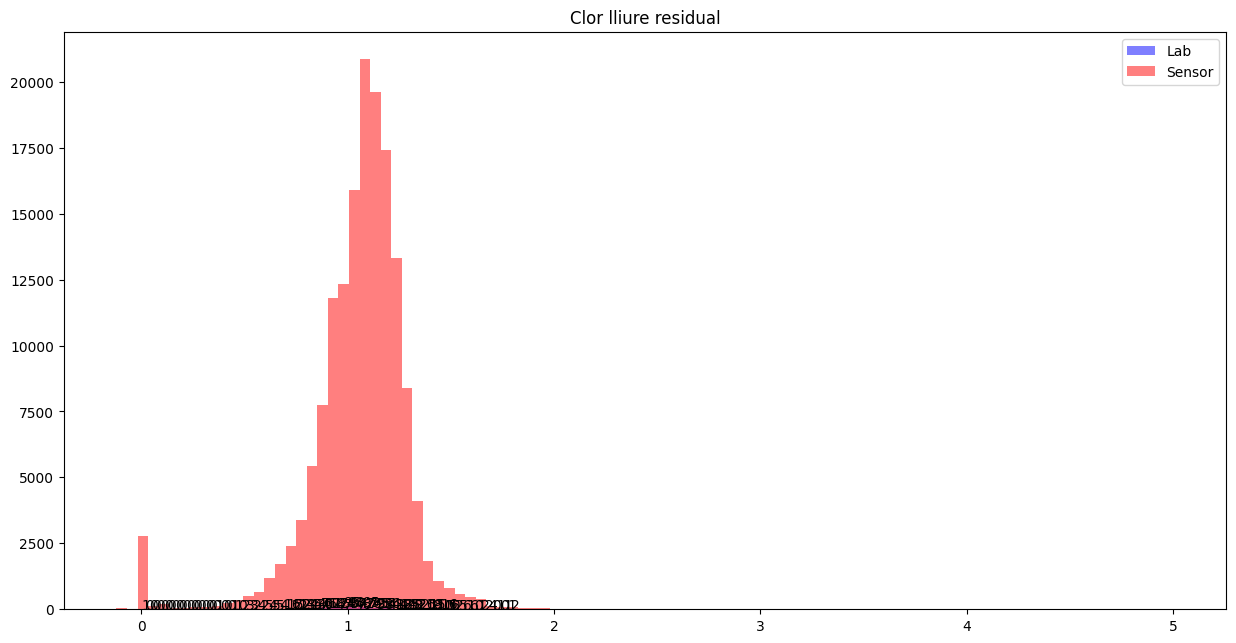

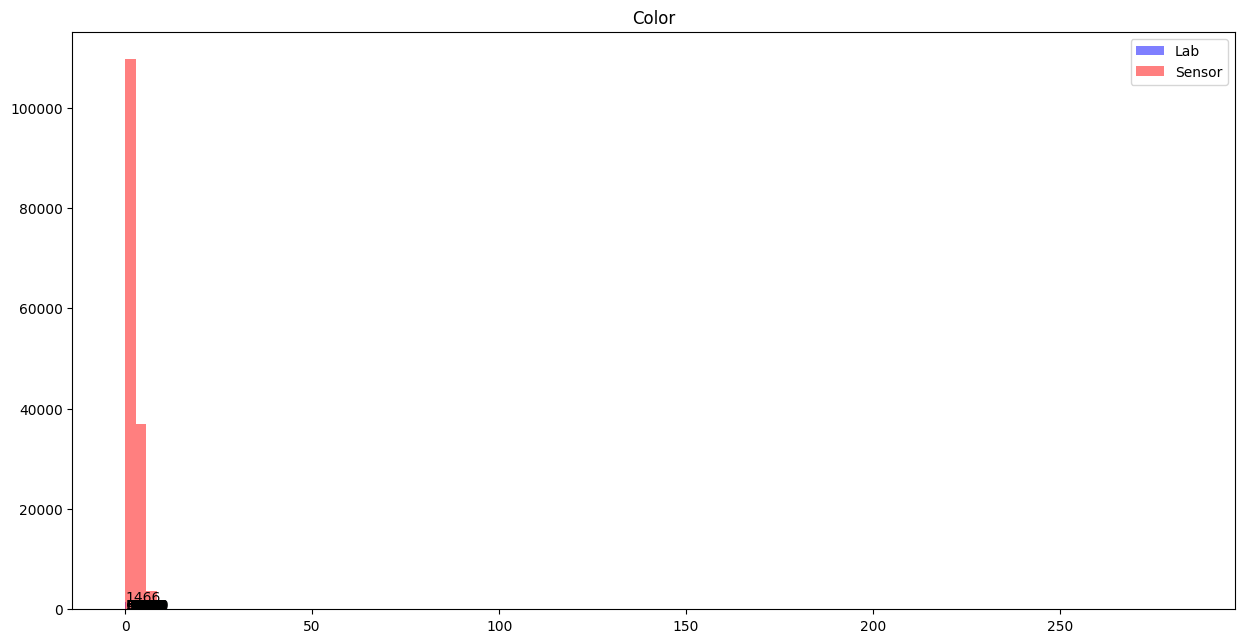

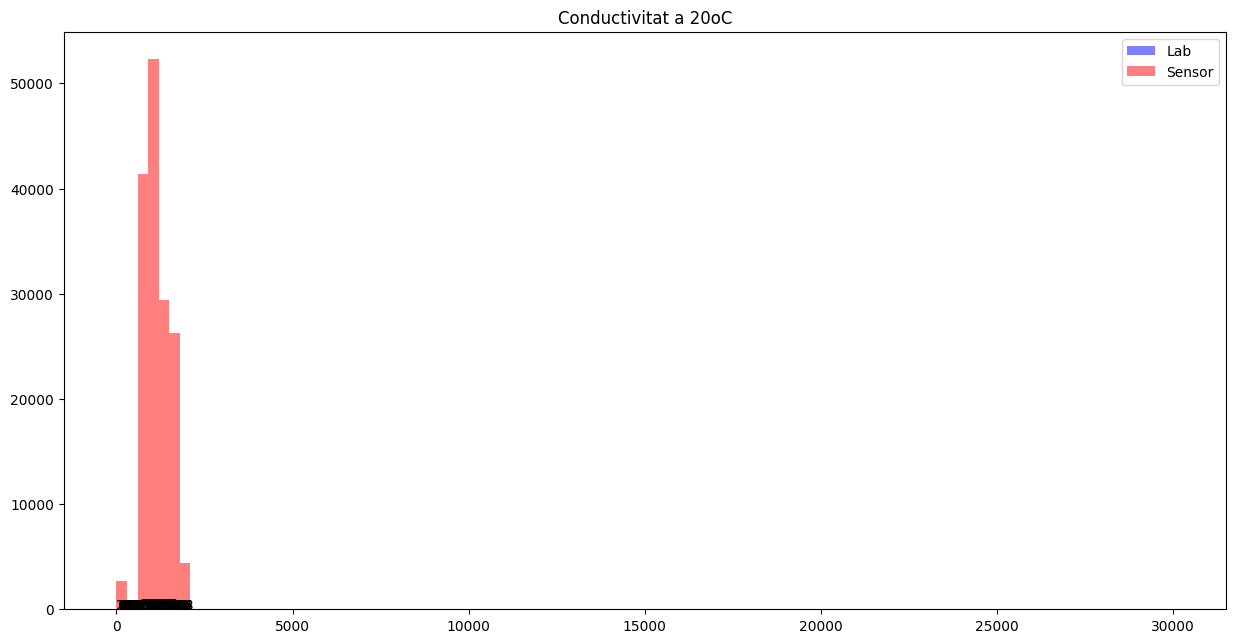

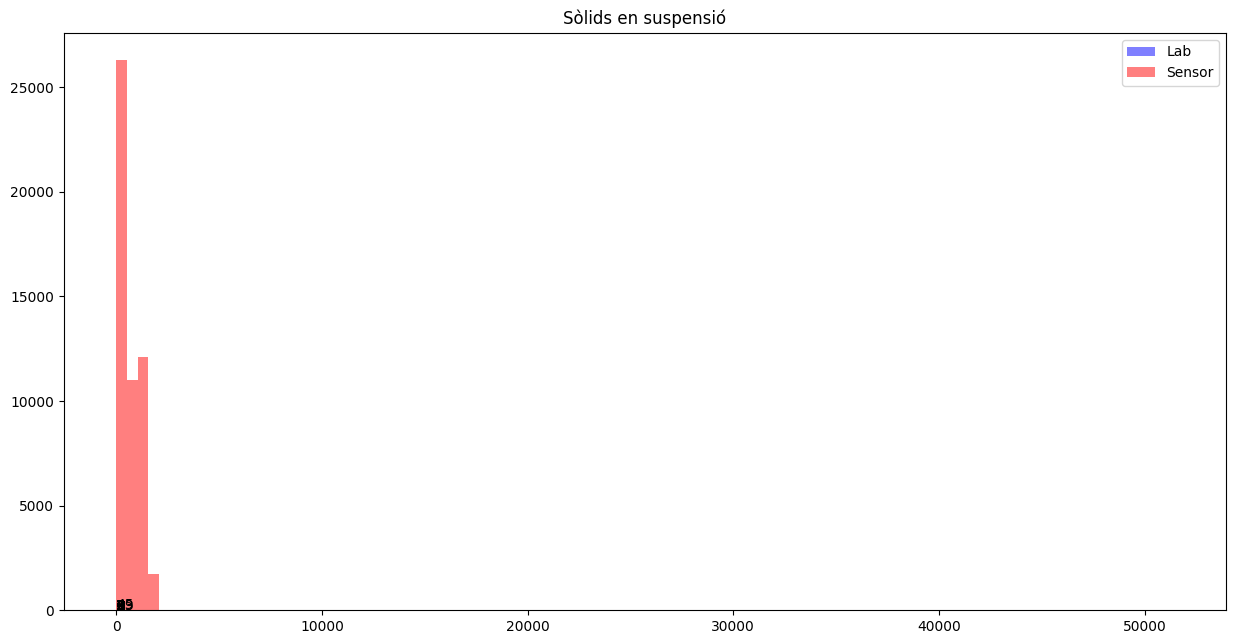

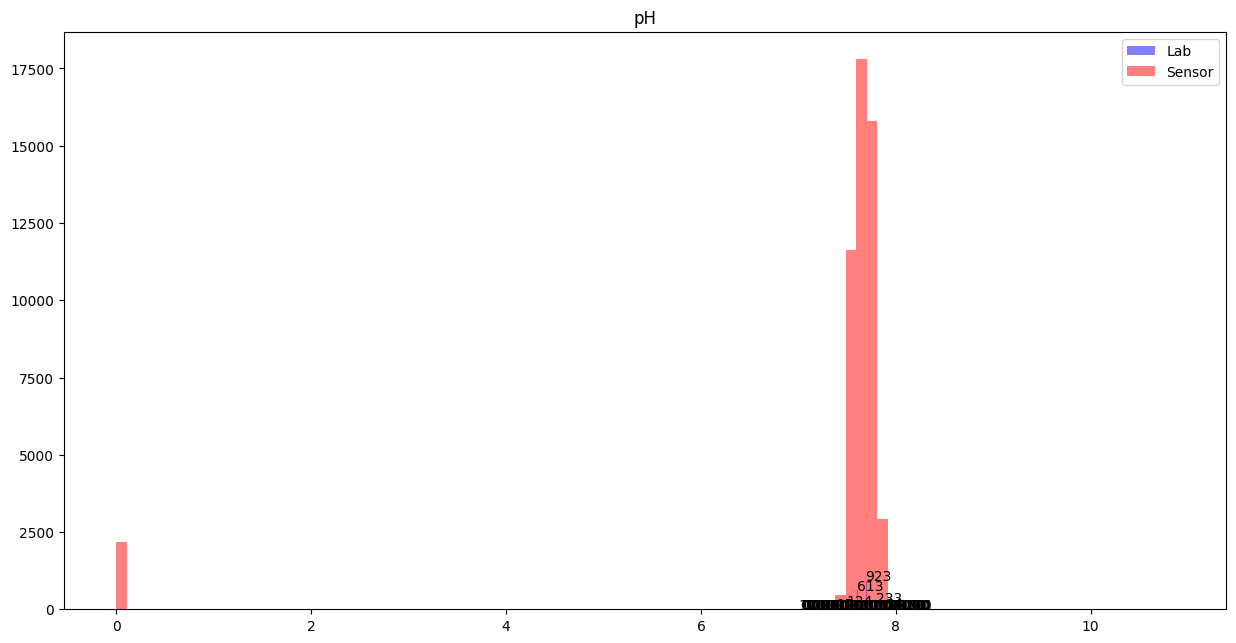

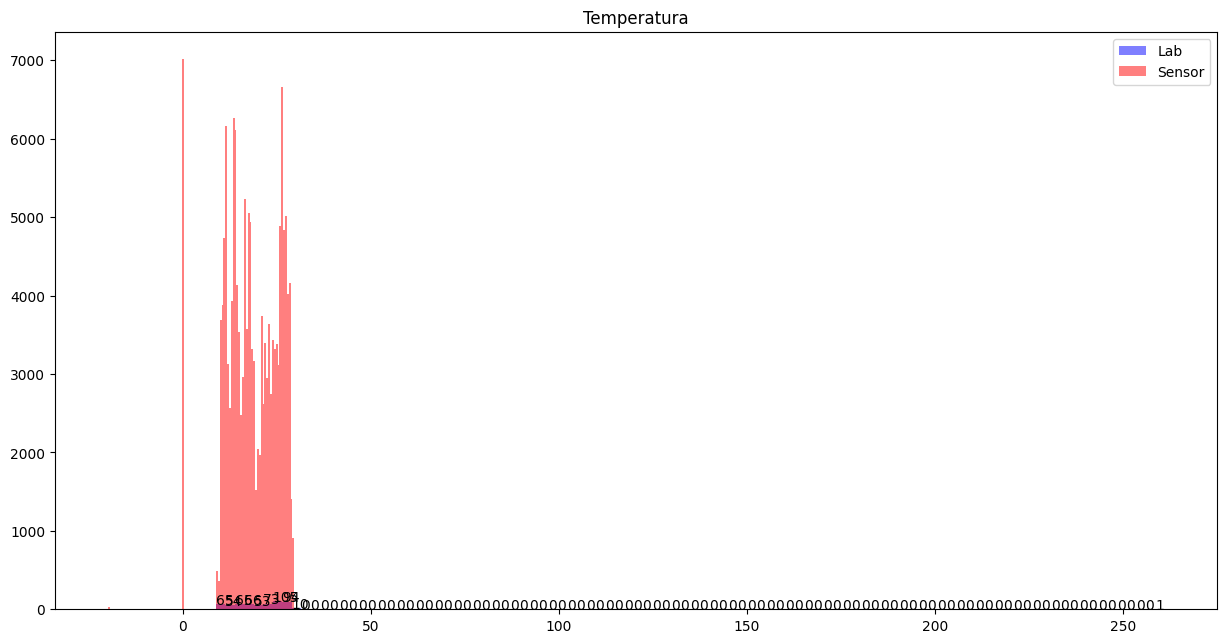

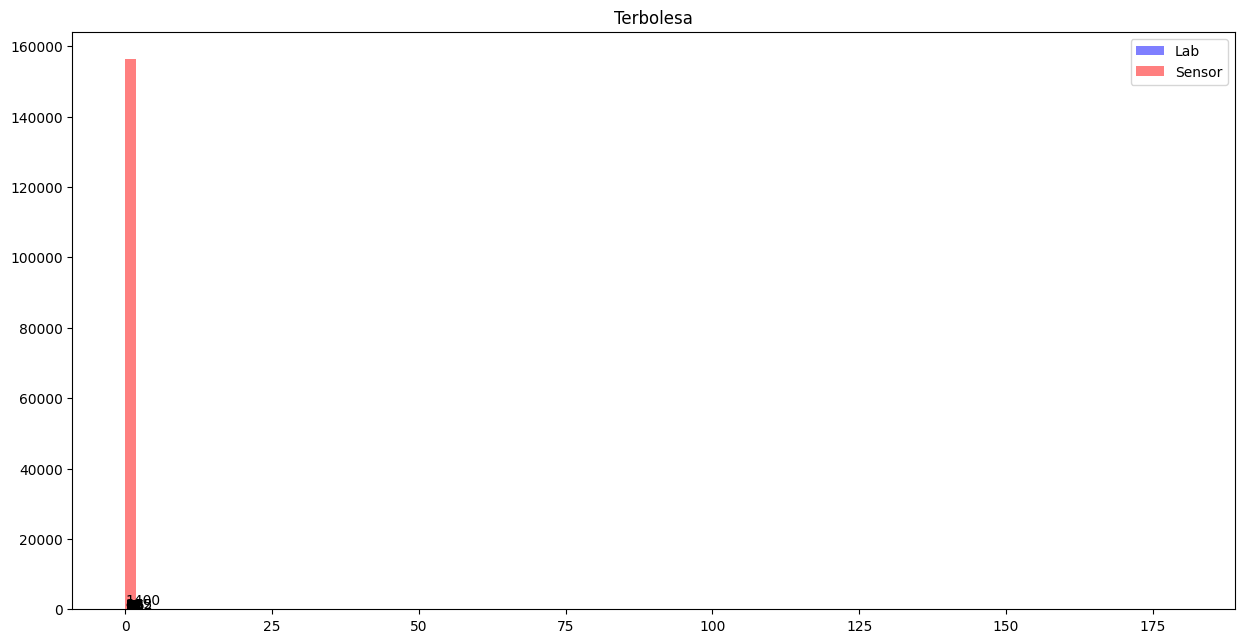

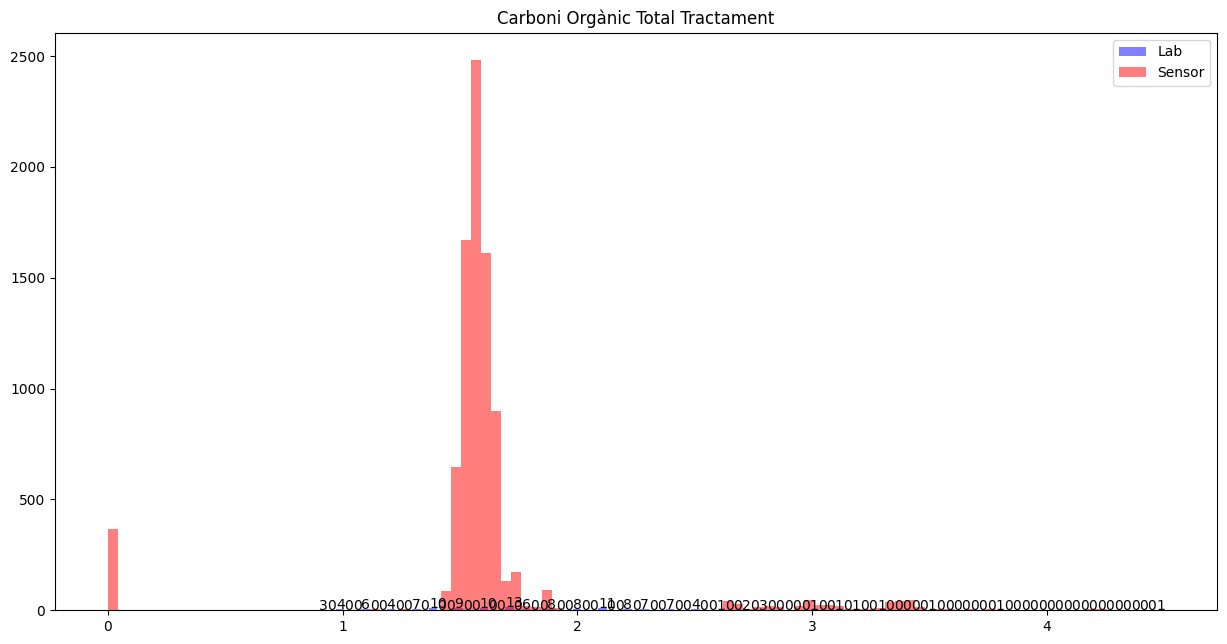

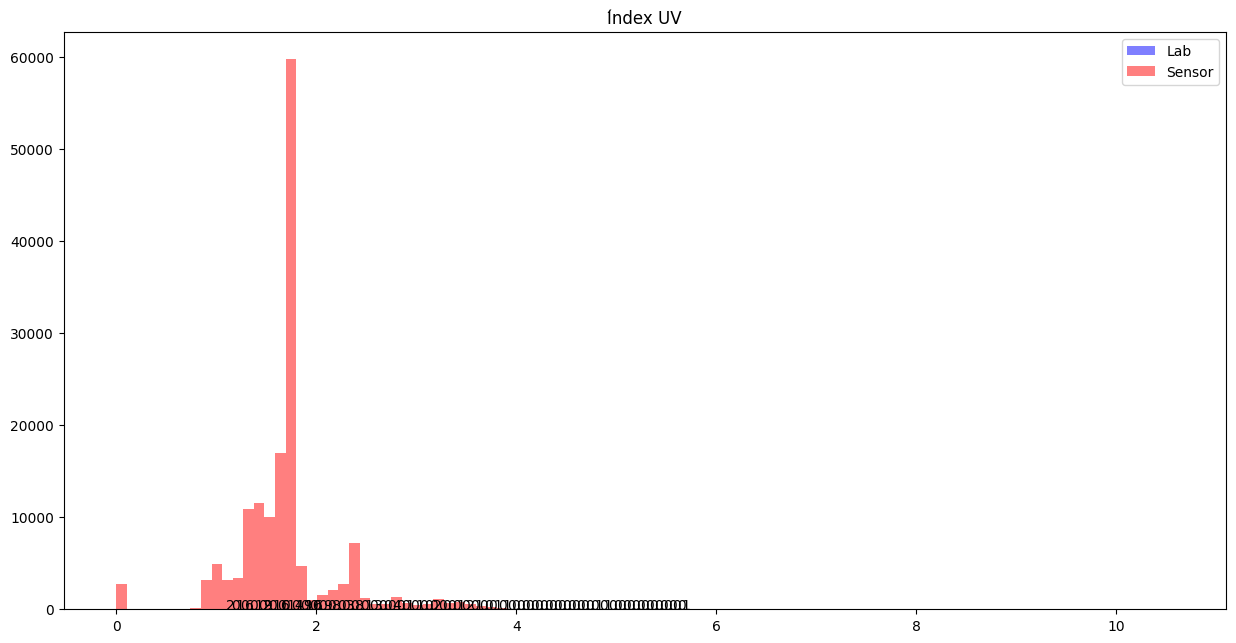

In [17]:
eb1_features_df['ANALYTE'] = eb1_features_df['ANALYTE'].apply(normalize_string)
eb1_features_mapping = {normalize_string(k): v for k, v in eb1_features_mapping.items()}

for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_df[eb1_features_df['ANALYTE'] == lab_key]
    sensor_df = eb1_sensors_dict[sensor_key]

    if not lab_df.empty and not sensor_df.empty:
        lab_df = lab_df.dropna(subset=['RESULTASNUMERIC'])

        plt.figure(figsize=(15, 7.5))

        counts, bins, patches = plt.hist(
            lab_df['RESULTASNUMERIC'],
            bins=100,
            color='blue',
            alpha=0.5,
            label='Lab'
        )
        # Add counts as annotations
        for count, bin in zip(counts, bins):
            plt.text(bin, count, str(int(count)))

        plt.hist(
            sensor_df[sensor_df.columns[1]],
            bins=100,
            color='red',
            alpha=0.5,
            label='Sensor'
        )
        plt.title(lab_key)
        plt.legend()
        plt.show()

### Distributions Divergence

In [18]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb1_features_mapping.items():

    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb1_features_df[eb1_features_df["ANALYTE"] == lab_key]
    sensor_df = eb1_sensors_dict[sensor_key]

    lab_pdist = np.histogram(
        lab_df["RESULTASNUMERIC"].dropna(), bins=100, density=True
    )[0]
    sensor_pdist = np.histogram(
        sensor_df[sensor_df.columns[1]].dropna(), bins=100, density=True
    )[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [19]:
kl_divs

Clor lliure residual                 26.470459
Color                                 3.695800
Conductivitat a 20oC                 25.805646
Sòlids en suspensió                 5.138382
pH                                   32.943491
Temperatura                          26.408554
Terbolesa                             8.969950
Carboni Orgànic Total Tractament    18.502190
Índex UV                             6.060536
dtype: float64

In [20]:
js_divs

Clor lliure residual                 0.816358
Color                                0.349428
Conductivitat a 20oC                 0.831327
Sòlids en suspensió                0.407581
pH                                   0.812533
Temperatura                          0.830845
Terbolesa                            0.334493
Carboni Orgànic Total Tractament    0.712805
Índex UV                            0.618463
dtype: float64

In [21]:
tv_dists

Clor lliure residual                 36.701434
Color                                 5.258180
Conductivitat a 20oC                  0.029621
Sòlids en suspensió                13.156924
pH                                   41.696142
Temperatura                           1.204670
Terbolesa                            45.176846
Carboni Orgànic Total Tractament    21.315555
Índex UV                            12.457702
dtype: float64

In [22]:
w_dists

Clor lliure residual                 0.357176
Color                                0.105157
Conductivitat a 20oC                 0.000527
Sòlids en suspensió                0.263138
pH                                   0.677081
Temperatura                          0.016189
Terbolesa                            0.903535
Carboni Orgànic Total Tractament    0.230015
Índex UV                            0.139317
dtype: float64

# Lab Data Feature-Target Analysis

## EB1 - THMs and others

In [40]:
eb1_features_df.head(20)

,DateTime,ENVSAMPOINTID,PROFILE,ANALYTE,RESULTASNUMERIC,units,OTHERCODE
0,2017-05-15 07:40:00,187,ACNEB1,Clor lliure residual,1.20,mg/L,173219
1,2017-05-15 07:40:00,187,ACNEB1,Color,0.00,mg Pt-Co/L,173219
2,2017-05-15 07:40:00,187,ACNEB1,Conductivitat a 20oC,852.00,µS/cm,173219
3,2017-05-15 07:40:00,187,ACNEB1,pH,7.70,Und pH,173219
4,2017-05-15 07:40:00,187,ACNEB1,Terbolesa,0.00,UNF,173219
5,2017-05-16 07:45:00,187,ACNEB1,Clor lliure residual,0.91,mg/L,173219
6,2017-05-16 07:45:00,187,ACNEB1,Color,0.00,mg Pt-Co/L,173219
7,2017-05-16 07:45:00,187,ACNEB1,Conductivitat a 20oC,857.00,µS/cm,173219
8,2017-05-16 07:45:00,187,ACNEB1,pH,7.70,Und pH,173219
9,2017-05-16 07:45:00,187,ACNEB1,Terbolesa,0.00,UNF,173219


In [41]:
# create dataframe from eb0 features df where for each datetime there is a row for each analyte of the same datetime with the corresponding resultasnumeric and units
eb1_features_df = eb1_features_df.pivot_table(index='DateTime', columns='ANALYTE', values='RESULTASNUMERIC', aggfunc='first')
eb1_features_df.reset_index(inplace=True)
eb1_features_df.head(20)

ANALYTE,DateTime,Carboni Orgànic Total Tractament,Clor lliure residual,Color,Conductivitat a 20oC,Índex UV,Sòlids en suspensió,Temperatura,Terbolesa,pH
0,2017-05-15 07:40:00,NaN,1.20,0.0,852.0,NaN,NaN,NaN,0.0,7.7
1,2017-05-16 07:45:00,NaN,0.91,0.0,857.0,NaN,NaN,NaN,0.0,7.7
2,2017-05-17 07:30:00,NaN,1.25,0.0,866.0,NaN,NaN,NaN,0.0,7.7
3,2017-05-18 07:30:00,NaN,1.04,0.0,863.0,NaN,NaN,NaN,0.0,8.0
4,2017-05-19 07:30:00,NaN,1.36,0.0,830.0,NaN,NaN,NaN,0.2,7.6
5,2017-05-20 07:15:00,NaN,1.20,0.0,826.0,NaN,NaN,NaN,0.3,7.7
6,2017-05-21 07:30:00,NaN,1.17,0.0,856.0,NaN,NaN,NaN,0.2,7.7
7,2017-05-22 07:15:00,4.5,0.72,0.0,864.0,2.0,NaN,NaN,0.0,7.5
8,2017-05-23 06:40:00,NaN,0.77,0.0,861.0,NaN,NaN,NaN,0.0,7.7
9,2017-05-23 13:37:00,NaN,0.51,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [42]:
eb1_targets_df = eb1_targets_df.pivot_table(index='DateTime', columns='ANALYTE', values='RESULTASNUMERIC', aggfunc='first')
eb1_targets_df.reset_index(inplace=True)
eb1_targets_df.head(20)

ANALYTE,DateTime,Bromodiclorometà,Bromoform,Clorat,Clorit,Cloroform,Dibromoclorometà,àcid bromocloroacètic,àcid dibromoacètic,àcid dicloroacètic,àcid monobromoacètic,àcid monocloroacètic
0,2017-05-15 07:40:00,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2017-05-22 07:15:00,0.0,2.7,0.0,0.0,0.0,4.9,1.3,1.7,0.8,0.0,0.0
2,2017-05-29 07:00:00,3.3,3.3,NaN,NaN,2.1,7.2,NaN,NaN,NaN,NaN,NaN
3,2017-06-05 07:30:00,2.2,2.5,NaN,0.0,1.7,5.3,1.3,1.7,0.7,0.0,0.0
4,2017-06-12 07:40:00,0.0,2.7,NaN,NaN,0.0,3.8,NaN,NaN,NaN,NaN,NaN
5,2017-06-19 08:00:00,0.0,2.6,NaN,NaN,0.0,3.6,1.5,1.5,1.0,0.0,0.0
6,2017-06-26 07:40:00,2.6,3.4,NaN,NaN,0.0,6.2,NaN,NaN,NaN,NaN,NaN
7,2017-07-03 07:15:00,0.0,2.5,NaN,0.0,0.0,4.1,1.4,1.9,1.0,0.0,0.0
8,2017-07-10 08:00:00,0.0,2.9,NaN,NaN,0.0,5.1,NaN,NaN,NaN,NaN,NaN
9,2017-07-17 07:15:00,0.0,3.1,NaN,NaN,0.0,4.7,0.8,2.0,0.0,5.9,0.0


In [43]:
# merge features and targets
eb1_df = pd.merge(eb1_features_df, eb1_targets_df, on='DateTime', how='inner')

In [44]:
eb1_df

ANALYTE,DateTime,Carboni Orgànic Total Tractament,Clor lliure residual,Color,Conductivitat a 20oC,Índex UV,Sòlids en suspensió,Temperatura,Terbolesa,pH,...,Bromoform,Clorat,Clorit,Cloroform,Dibromoclorometà,àcid bromocloroacètic,àcid dibromoacètic,àcid dicloroacètic,àcid monobromoacètic,àcid monocloroacètic
0,2017-05-15 07:40:00,NaN,1.20,0.0,852.0,NaN,NaN,NaN,0.00,7.7,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2017-05-22 07:15:00,4.5,0.72,0.0,864.0,2.0,NaN,NaN,0.00,7.5,...,2.7,0.0,0.0,0.0,4.9,1.3,1.7,0.8,0.0,0.0
2,2017-05-29 07:00:00,NaN,0.55,0.0,860.0,NaN,NaN,NaN,0.00,7.7,...,3.3,NaN,NaN,2.1,7.2,NaN,NaN,NaN,NaN,NaN
3,2017-06-05 07:30:00,3.8,1.32,0.0,902.0,2.4,NaN,22.0,0.00,7.9,...,2.5,NaN,0.0,1.7,5.3,1.3,1.7,0.7,0.0,0.0
4,2017-06-12 07:40:00,NaN,1.20,0.0,894.0,NaN,NaN,NaN,0.00,7.7,...,2.7,NaN,NaN,0.0,3.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2022-12-19 06:45:00,1.5,1.18,0.9,1721.0,1.8,NaN,14.7,0.07,7.7,...,4.0,127.0,0.0,0.0,4.1,0.8,2.2,0.0,0.0,0.0
233,2022-12-27 07:00:00,NaN,1.06,0.1,1655.0,NaN,NaN,14.5,0.13,7.7,...,5.3,NaN,NaN,0.0,5.4,NaN,NaN,NaN,NaN,NaN
234,2023-01-02 06:55:00,1.4,1.06,0.1,1580.0,1.8,NaN,13.7,0.10,7.8,...,4.0,136.0,0.0,0.0,4.3,0.9,2.3,0.0,0.0,0.0
235,2023-01-09 08:30:00,NaN,0.91,0.1,1583.0,NaN,NaN,14.3,0.11,7.8,...,3.6,NaN,NaN,0.0,3.6,NaN,NaN,NaN,NaN,NaN


## Correlation Matrix Heatmap

[Text(0.5, 0, 'Carboni Orgànic Total Tractament'),
 Text(1.5, 0, 'Clor lliure residual'),
 Text(2.5, 0, 'Color'),
 Text(3.5, 0, 'Conductivitat a 20oC'),
 Text(4.5, 0, 'Índex UV'),
 Text(5.5, 0, 'Sòlids en suspensió'),
 Text(6.5, 0, 'Temperatura'),
 Text(7.5, 0, 'Terbolesa'),
 Text(8.5, 0, 'pH'),
 Text(9.5, 0, 'Bromodiclorometà'),
 Text(10.5, 0, 'Bromoform'),
 Text(11.5, 0, 'Clorat'),
 Text(12.5, 0, 'Clorit'),
 Text(13.5, 0, 'Cloroform'),
 Text(14.5, 0, 'Dibromoclorometà'),
 Text(15.5, 0, 'àcid bromocloroacètic'),
 Text(16.5, 0, 'àcid dibromoacètic'),
 Text(17.5, 0, 'àcid dicloroacètic'),
 Text(18.5, 0, 'àcid monobromoacètic'),
 Text(19.5, 0, 'àcid monocloroacètic')]

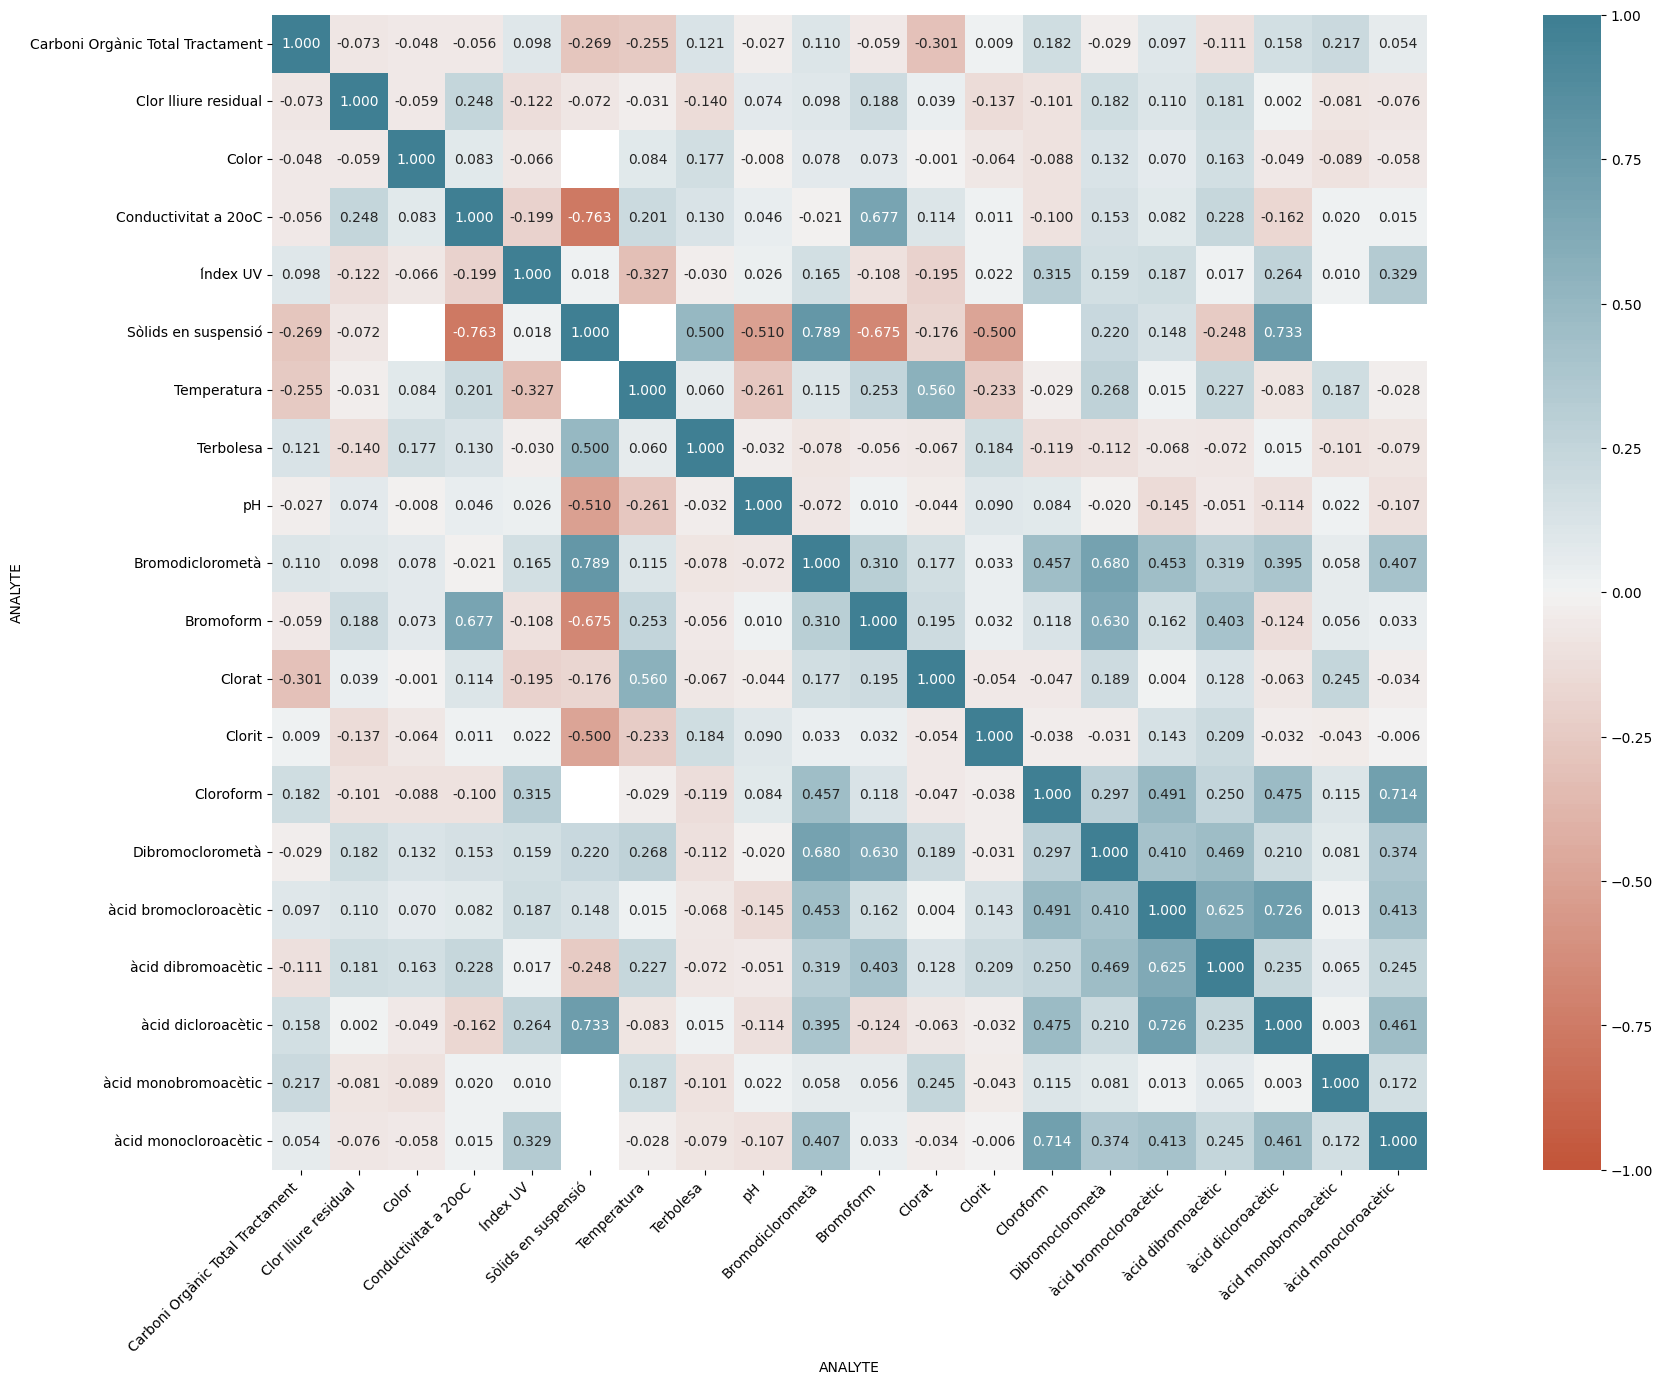

In [46]:
corr = eb1_df[eb1_df.columns[1:]].corr(method="pearson")

plt.figure(figsize=(30, 15))
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    fmt=".3f",
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45, horizontalalignment="right"
)

## Hypothesis Tests Correlations

In [52]:
import itertools

for (col_1, col_2) in itertools.combinations(eb1_df.columns[1:], 2):

    mask = ~np.logical_or(np.isnan(eb1_df[col_1]), np.isnan(eb1_df[col_2]))

    eb1_col_1 = np.compress(mask, eb1_df[col_1])
    eb1_col_2 = np.compress(mask, eb1_df[col_2])

    try:
        r, p = stats.pearsonr(
            eb1_col_1, eb1_col_2
        )
    except ValueError:
        r = np.nan
        p = np.nan
        
    print(f"==== {col_1} - {col_2} ====")
    print("Pearsons correlation: ", r)
    print("Pearsons p-value: ", p)
    print()


==== Carboni Orgànic Total Tractament - Clor lliure residual ====
Pearsons correlation:  -0.07316398189709986
Pearsons p-value:  0.4432975632351732

==== Carboni Orgànic Total Tractament - Color ====
Pearsons correlation:  -0.04782246630473075
Pearsons p-value:  0.6165721815127072

==== Carboni Orgànic Total Tractament - Conductivitat a 20oC ====
Pearsons correlation:  -0.05573319711876909
Pearsons p-value:  0.5576599923133613

==== Carboni Orgànic Total Tractament - Índex UV ====
Pearsons correlation:  0.09751788021958742
Pearsons p-value:  0.25871170511436364

==== Carboni Orgànic Total Tractament - Sòlids en suspensió ====
Pearsons correlation:  -0.26892643710023867
Pearsons p-value:  0.6063349164054987

==== Carboni Orgànic Total Tractament - Temperatura ====
Pearsons correlation:  -0.25462463604084035
Pearsons p-value:  0.018689485729535486

==== Carboni Orgànic Total Tractament - Terbolesa ====
Pearsons correlation:  0.12134145259444157
Pearsons p-value:  0.202498325198

/Users/massimilianoarca/Library/Caches/pypoetry/virtualenvs/safecrew-3OLHM_8n-py3.12/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


==== Clorat - àcid dicloroacètic ====
Pearsons correlation:  -0.06336434615100302
Pearsons p-value:  0.4917376610334505

==== Clorat - àcid monobromoacètic ====
Pearsons correlation:  0.2454965504987555
Pearsons p-value:  0.006879509698902472

==== Clorat - àcid monocloroacètic ====
Pearsons correlation:  -0.03443435030452846
Pearsons p-value:  0.7088716344797285

==== Clorit - Cloroform ====
Pearsons correlation:  -0.03831173649499877
Pearsons p-value:  0.6639582044545037

==== Clorit - Dibromoclorometà ====
Pearsons correlation:  -0.03144031760478611
Pearsons p-value:  0.7214735053986113

==== Clorit - àcid bromocloroacètic ====
Pearsons correlation:  0.14327435110476405
Pearsons p-value:  0.11093638972630106

==== Clorit - àcid dibromoacètic ====
Pearsons correlation:  0.20852842750286132
Pearsons p-value:  0.019610746836452187

==== Clorit - àcid dicloroacètic ====
Pearsons correlation:  -0.031881151483476165
Pearsons p-value:  0.7241252291536113

==== Clorit - àcid monobromoacètic

## Scatter Plots

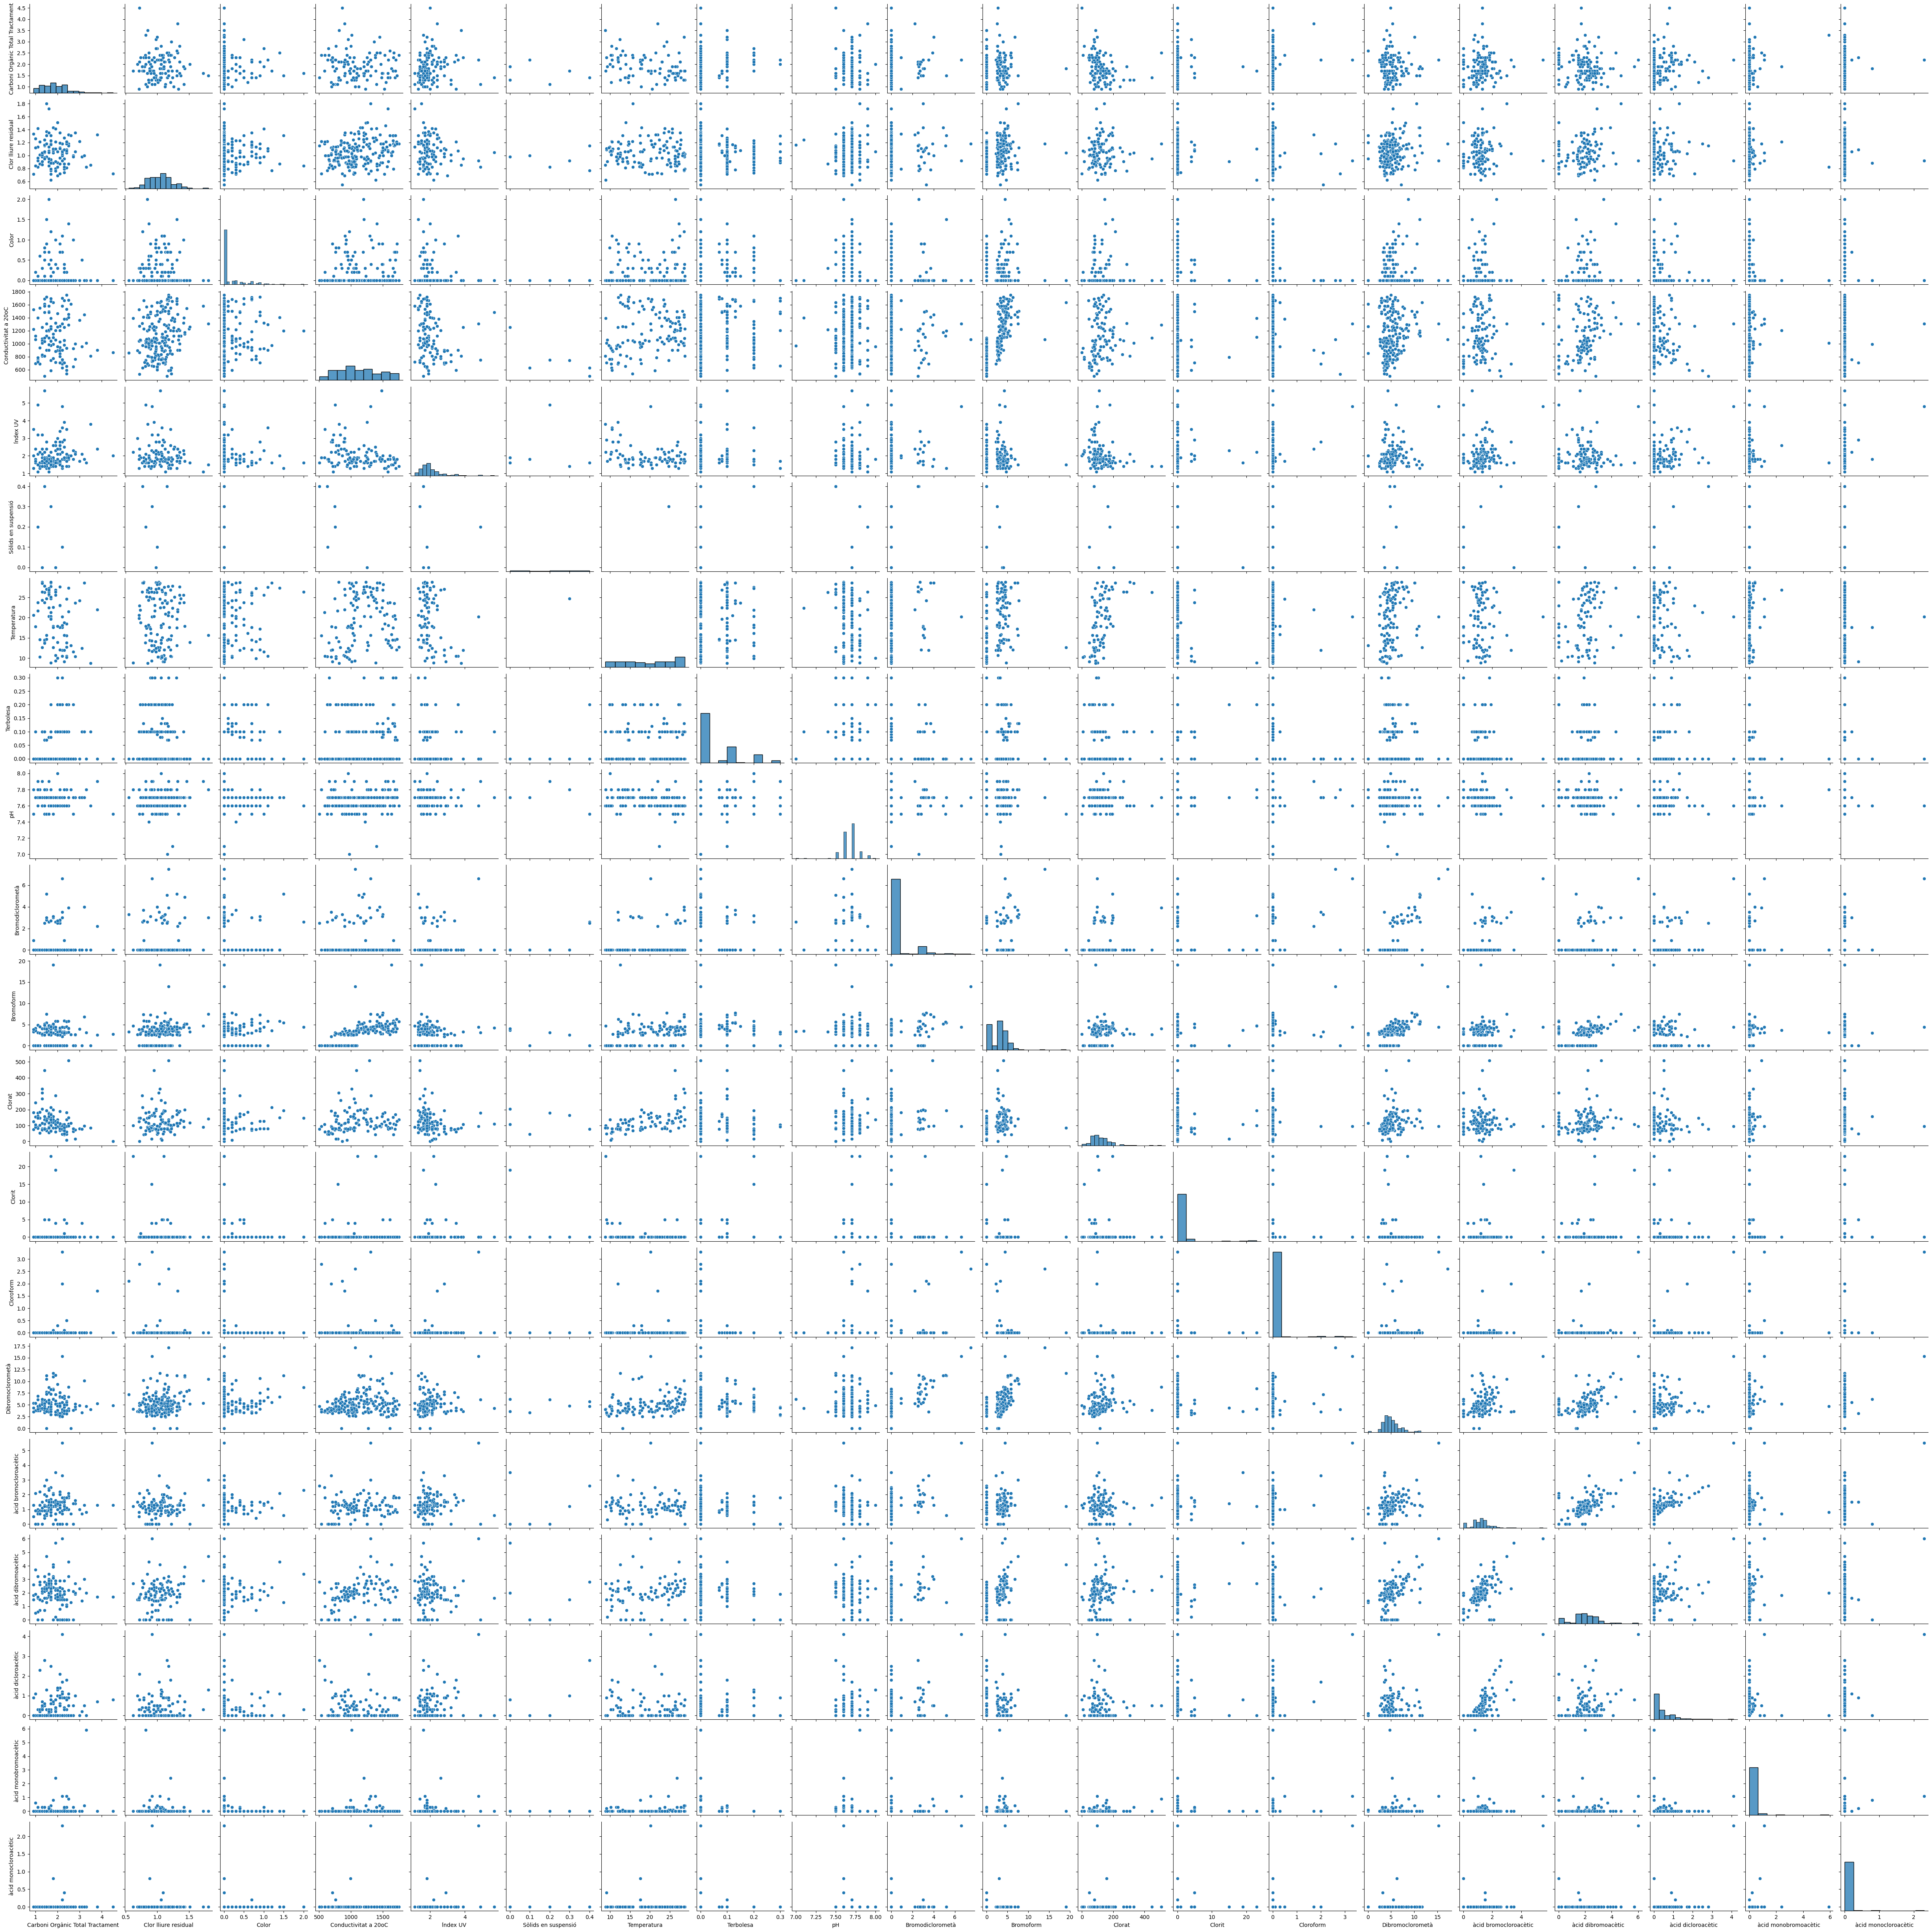

In [48]:
sns.pairplot(eb1_df[eb1_df.columns[1:]])

## Boxplots

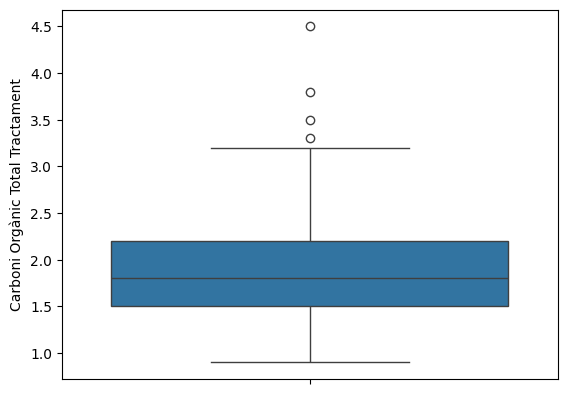

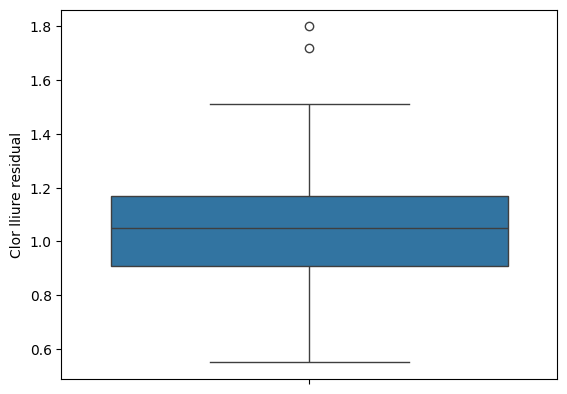

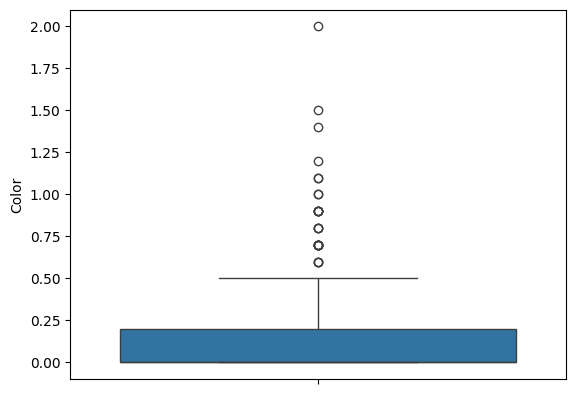

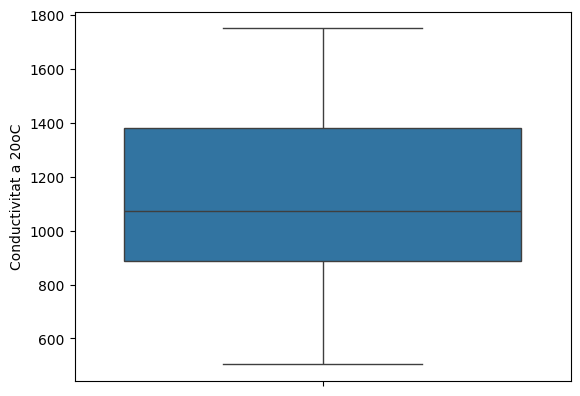

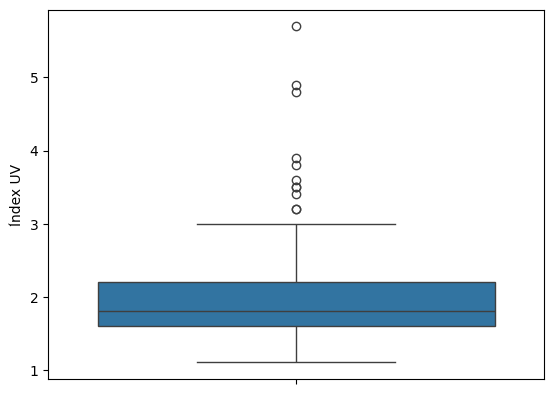

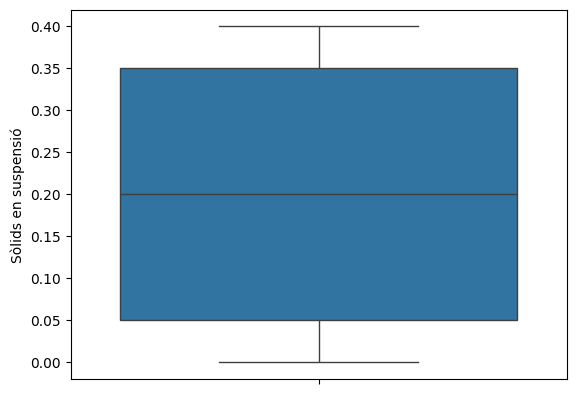

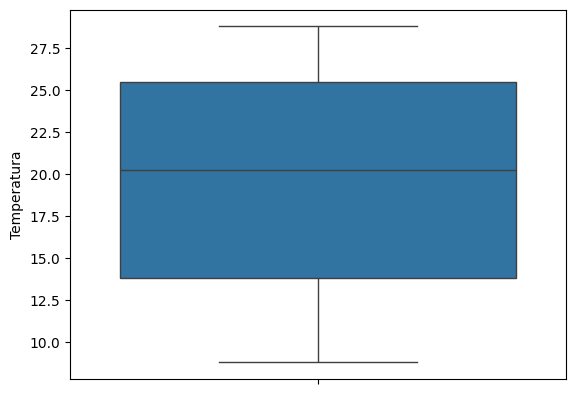

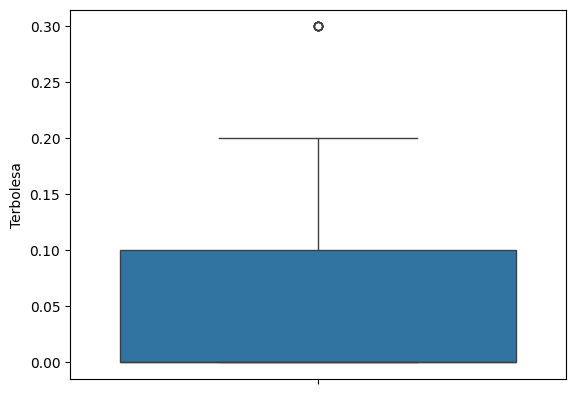

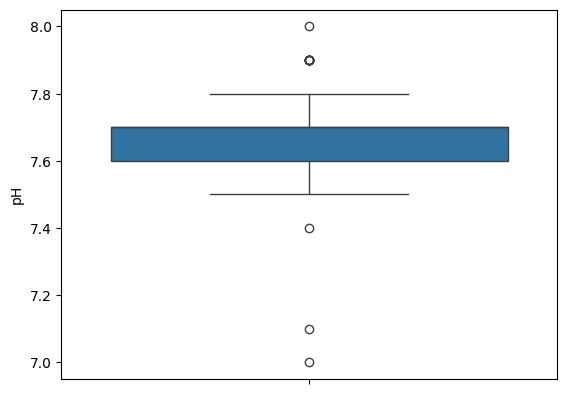

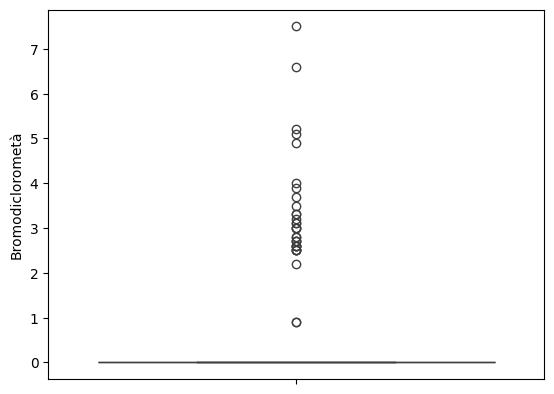

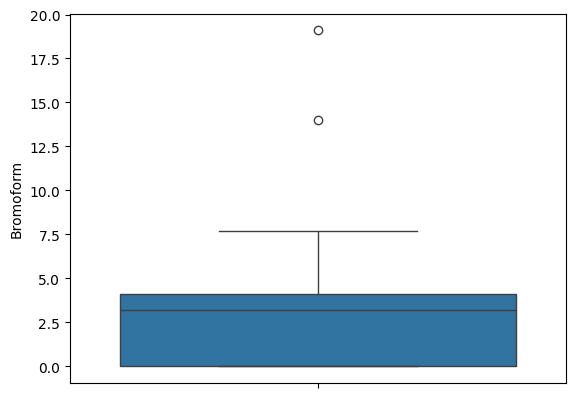

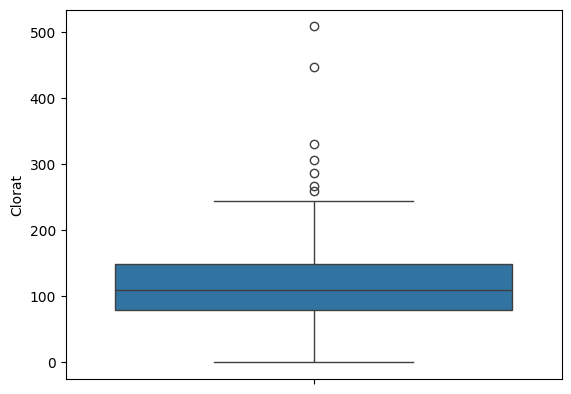

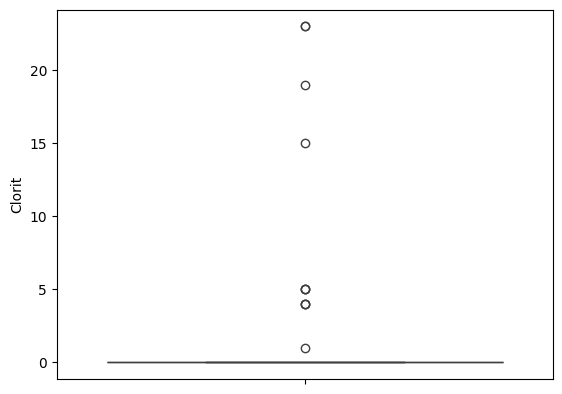

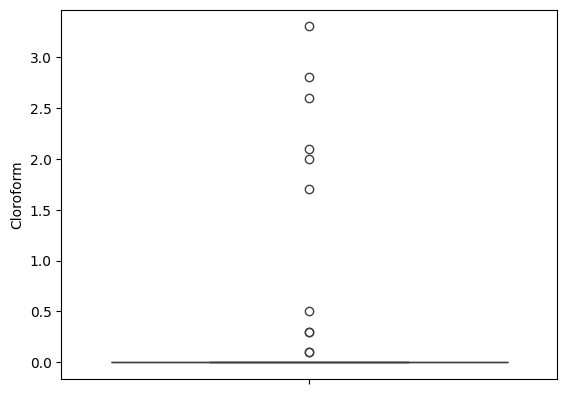

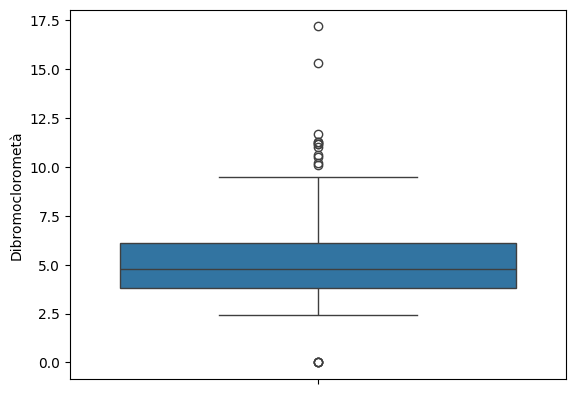

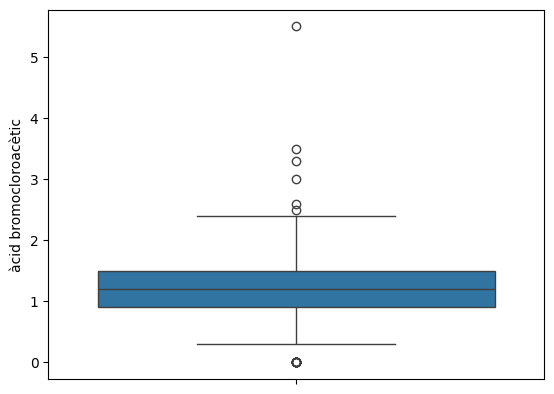

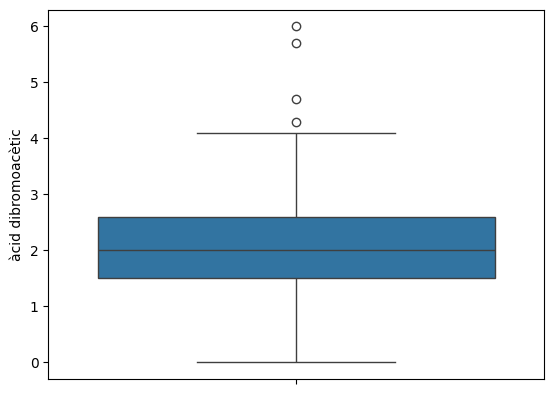

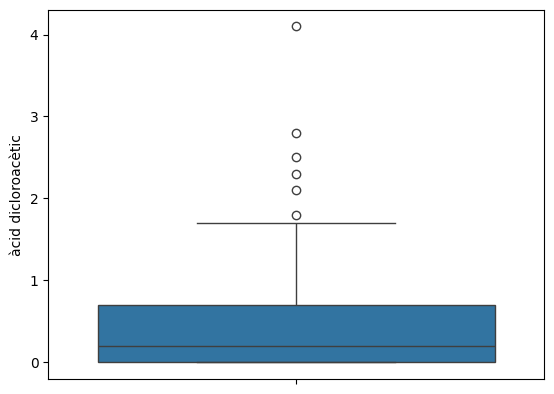

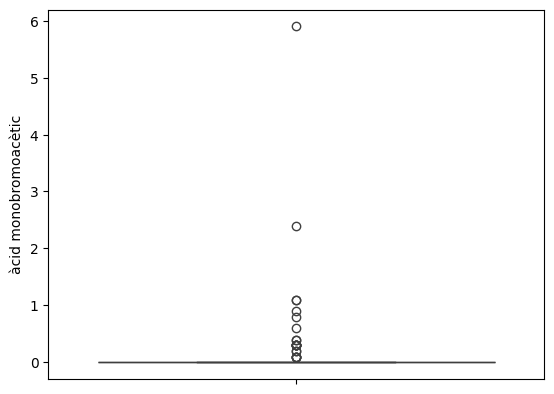

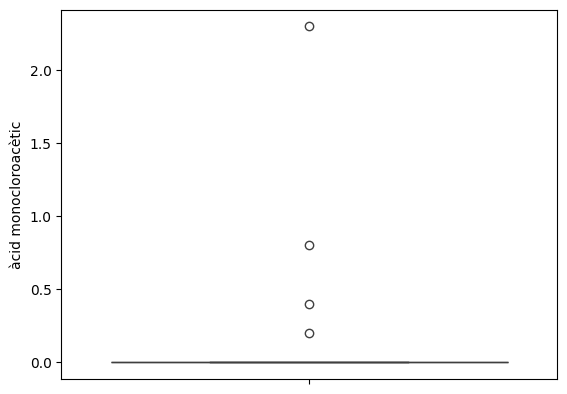

In [49]:
for col in eb1_df.columns[1:]:
    plt.figure()
    sns.boxplot(y=eb1_df[col], orient="v")